In [40]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
import numpy as np
from scipy.optimize import minimize

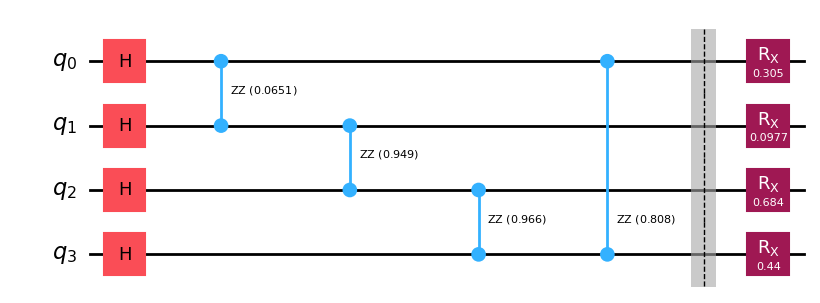

In [28]:
depth = 1
nqubits = 4
params = np.random.random(2 * depth * nqubits)
ansatz_hamiltonian(nqubits, depth, params).draw('mpl')

In [49]:
hamiltonian = build_tfim_hamiltonian_2x2()[0]
np.linalg.eigh(hamiltonian.to_matrix())[0]

array([-5.22625186e+00, -4.82842712e+00, -2.16478440e+00, -2.00000000e+00,
       -2.00000000e+00, -8.28427125e-01, -1.16086666e-15, -4.23027238e-16,
        1.94714979e-17,  1.21132467e-16,  8.28427125e-01,  2.00000000e+00,
        2.00000000e+00,  2.16478440e+00,  4.82842712e+00,  5.22625186e+00])

# VQE without post-selection

✅ depth=1, final energy=-4.558641, iterations=30
✅ depth=2, final energy=-5.206675, iterations=23
✅ depth=3, final energy=-5.206675, iterations=22
✅ depth=4, final energy=-5.206675, iterations=22
✅ depth=5, final energy=-5.206675, iterations=21
✅ depth=6, final energy=-5.206675, iterations=17


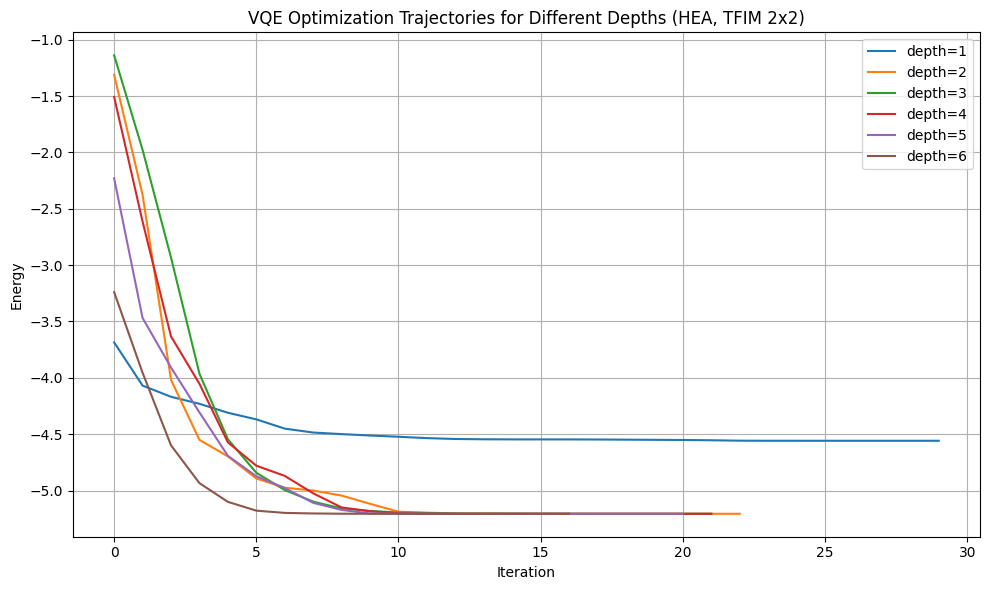

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

# === TFIM 2x2 Hamiltonian ===
def build_tfim_hamiltonian_2x2():
    nrow, ncol = 2, 2
    nqubits = nrow * ncol
    pauli_terms, coeffs = [], []

    def idx(r, c):
        return r * ncol + c

    for r in range(nrow):
        for c in range(ncol):
            q = idx(r, c)
            if c < ncol - 1:
                q_r = idx(r, c + 1)
                zz = ['I'] * nqubits
                zz[q], zz[q_r] = 'Z', 'Z'
                pauli_terms.append(''.join(reversed(zz)))
                coeffs.append(1.0)
            if r < nrow - 1:
                q_d = idx(r + 1, c)
                zz = ['I'] * nqubits
                zz[q], zz[q_d] = 'Z', 'Z'
                pauli_terms.append(''.join(reversed(zz)))
                coeffs.append(1.0)

    for i in range(nqubits):
        x = ['I'] * nqubits
        x[i] = 'X'
        pauli_terms.append(''.join(reversed(x)))
        coeffs.append(-1.0)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs))), nqubits
# 构造 HVA ansatz
def ansatz_hamiltonian(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0    
            circuit.rx(params[t], i)
            t += 1
    return circuit   


# 计算能量
def cost_function2(params, nqubits, depth, error_rate):
    hamiltonian = build_tfim_hamiltonian_2x2()[0]
    circuit = ansatz_hamiltonian(nqubits, depth, params)
    circuit = circuit.decompose()
    simulator = AerSimulator()
    circuit.save_statevector()
    result = simulator.run(circuit).result()
    u = result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real

# callback函数工厂
def make_callback(tracker, nqubits, depth, error_rate):
    def callback(xk):
        energy = cost_function2(xk, nqubits, depth, error_rate)
        tracker.append(energy)
    return callback

# 单次运行VQE
def run_vqe(nqubits, depth, error_rate):
    np.random.seed(42)
    nparams = 2 * nqubits * depth
    params0 = np.random.random(nparams)
    tracker = []
    callback_fn = make_callback(tracker, nqubits, depth, error_rate)
    result = minimize(cost_function2, params0, args=(nqubits, depth, error_rate),
                      method="BFGS", tol=1e-5, callback=callback_fn)
    return result.fun, tracker

# 主程序：多depth运行并绘图
depths = [1, 2, 3, 4, 5, 6]
nqubits = 4
error_rate = 0

results = {}
for d in depths:
    final_energy, trajectory = run_vqe(nqubits, d, error_rate)
    results[d] = trajectory
    print(f"✅ depth={d}, final energy={final_energy:.6f}, iterations={len(trajectory)}")

# 画图
plt.figure(figsize=(10, 6))
for d, traj in results.items():
    plt.plot(traj, label=f"depth={d}")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Optimization Trajectories for Different Depths (HEA, TFIM 2x2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


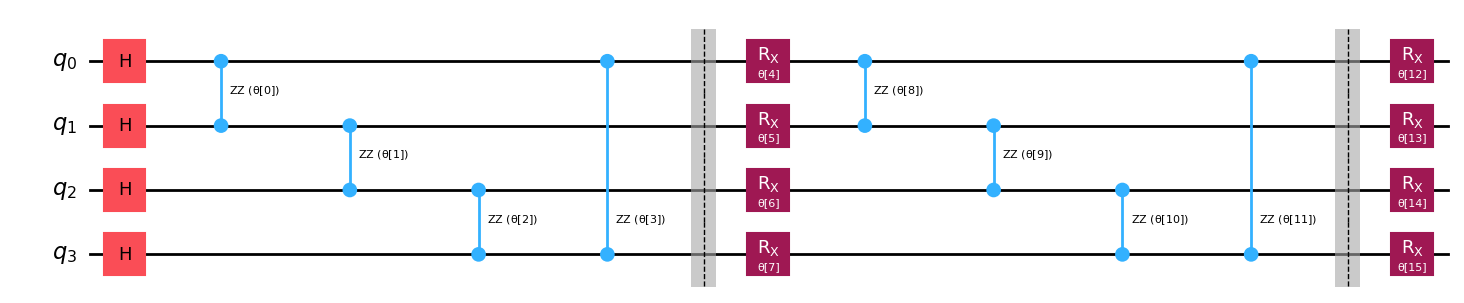

In [72]:
ansatz_hamiltonian(4, 2, ParameterVector('θ', 2*4*2+3)).draw('mpl', fold=60)

# Post-selection VQE

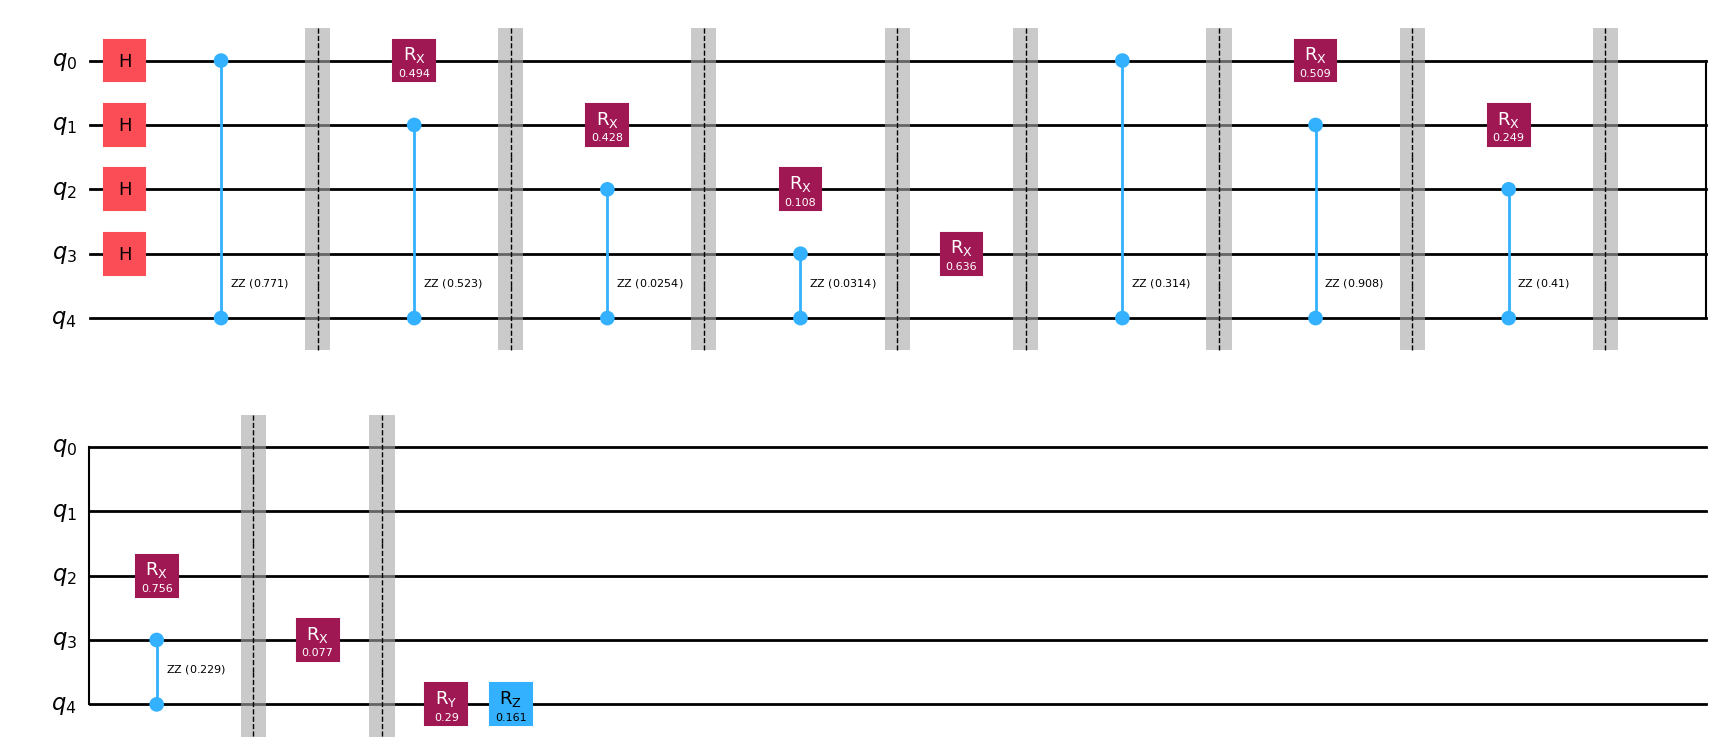

In [196]:
from qiskit import QuantumCircuit

def vps_ansatz_ancilla_rzz_swap_include_last(nqubits, depth, params):
    """
    VPS ansatz:
    - ancilla = q[nqubits], sequentially interacts with all system qubits via:
        RZZ(q[nqubits], qi) + SWAP(q[nqubits], qi)
    - ensures q[nqubits-1] is included
    - SU(2) is applied at the fixed ancilla location (q[nqubits])
    """
    total_qubits = nqubits + 1
    ancilla = nqubits
    circuit = QuantumCircuit(total_qubits)
    t = 0

    # Hadamard on system qubits
    for i in range(nqubits):
        circuit.h(i)

    for _ in range(depth):
        for i in range(nqubits):
            circuit.rzz(params[t], ancilla, i)
            t += 1
            #circuit.swap(ancilla, i)  # logical ancilla label remains q[nqubits]
            circuit.barrier()
            circuit.rx(params[t], i)
            t+=1
            
        circuit.barrier()
        # for i in range(total_qubits):
        #     circuit.rz(params[t], i)
        #     t+=1
        # circuit.barrier()

    # Final SU(2) on ancilla (q[nqubits])
    circuit.ry(params[t], ancilla)
    t += 1
    circuit.rz(params[t], ancilla)
    t += 1
    #circuit.ry(params[t], ancilla)

    return circuit
params = np.random.random(nqubits*depth*2+3)
qc = vps_ansatz_ancilla_rzz_swap_include_last(nqubits, depth, params)
qc.draw("mpl")

✅ Depth=1, Final Energy=-4.000000, Steps=6
✅ Depth=2, Final Energy=-5.000000, Steps=23
✅ Depth=3, Final Energy=-5.000000, Steps=23
✅ Depth=4, Final Energy=-5.000000, Steps=22
✅ Depth=5, Final Energy=-5.000000, Steps=17
✅ Depth=6, Final Energy=-5.000000, Steps=19


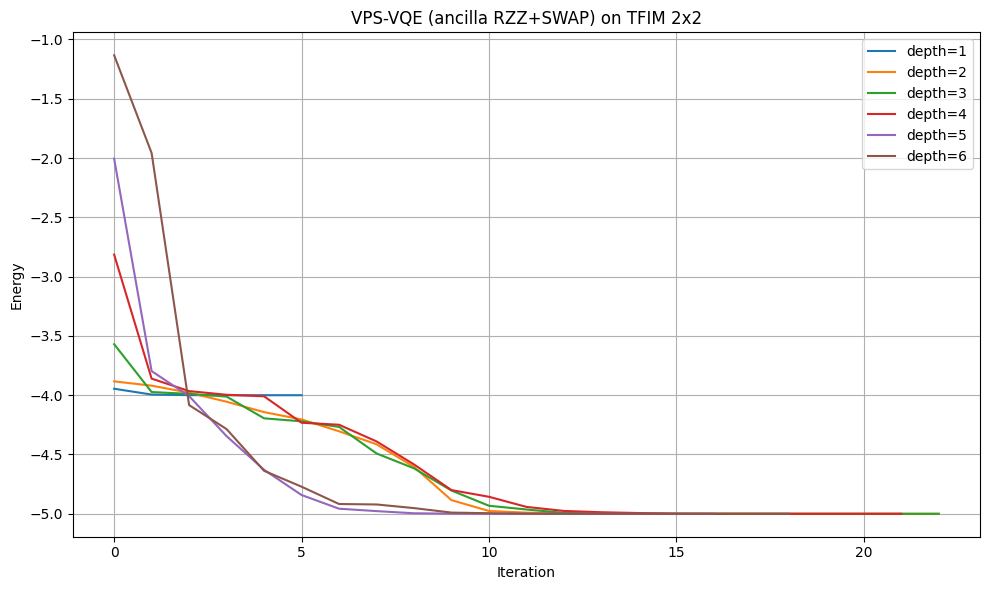

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

# === TFIM 2x2 Hamiltonian ===
def build_tfim_hamiltonian_2x2():
    nrow, ncol = 2, 2
    nqubits = nrow * ncol
    pauli_terms, coeffs = [], []

    def idx(r, c):
        return r * ncol + c

    for r in range(nrow):
        for c in range(ncol):
            q = idx(r, c)
            if c < ncol - 1:
                q_r = idx(r, c + 1)
                zz = ['I'] * nqubits
                zz[q], zz[q_r] = 'Z', 'Z'
                pauli_terms.append(''.join(reversed(zz)))
                coeffs.append(1.0)
            if r < nrow - 1:
                q_d = idx(r + 1, c)
                zz = ['I'] * nqubits
                zz[q], zz[q_d] = 'Z', 'Z'
                pauli_terms.append(''.join(reversed(zz)))
                coeffs.append(1.0)

    for i in range(nqubits):
        x = ['I'] * nqubits
        x[i] = 'X'
        pauli_terms.append(''.join(reversed(x)))
        coeffs.append(-1.0)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs))), nqubits

# === VPS ansatz: ancilla RZZ + SWAP ===
def vps_ansatz_right_to_left_rzz_swap(nqubits, depth, params):
    """
    VPS ansatz (right-to-left version):
    - ancilla starts at q[nqubits]
    - for i in reversed(range(nqubits)):
        RZZ(q[i], ancilla) + SWAP(q[i], ancilla)
    - ancilla "moves" from q[n] to q[0] (via SWAP)
    - SU(2) is applied on the ancilla's final location
    """
    total_qubits = nqubits + 1
    ancilla_start = nqubits
    circuit = QuantumCircuit(total_qubits)
    t = 0

    # 初始化系统 qubit
    for i in range(nqubits):
        circuit.h(i)

    for _ in range(depth):
        anc_pos = ancilla_start
        for i in reversed(range(nqubits)):
            circuit.rzz(params[t], i, anc_pos)
            t += 1
            circuit.swap(i, anc_pos)
            anc_pos = i  # ancilla 的状态被推进到 q[i]
        circuit.barrier()

    # 最终在 ancilla 位置做 SU(2)
    circuit.ry(params[t], ancilla_start)
    t += 1
    circuit.rz(params[t], ancilla_start)
    t += 1
    #circuit.ry(params[t], ancilla_start)

    return circuit


def vps_ansatz_ancilla_rzz_swap_include_last(nqubits, depth, params):
    """
    VPS ansatz:
    - ancilla = q[nqubits], sequentially interacts with all system qubits via:
        RZZ(q[nqubits], qi) + SWAP(q[nqubits], qi)
    - ensures q[nqubits-1] is included
    - SU(2) is applied at the fixed ancilla location (q[nqubits])
    """
    total_qubits = nqubits + 1
    ancilla = nqubits
    circuit = QuantumCircuit(total_qubits)
    t = 0
    #circuit.h(nqubits)
    #circuit.s(nqubits)

    # Hadamard on system qubits
    
    for i in range(nqubits):
        circuit.h(i)

    for _ in range(depth):
        for i in range(nqubits):
            circuit.rzz(params[t], ancilla, i)
            t += 1
            #circuit.swap(ancilla, i)  # logical ancilla label remains q[nqubits]
            circuit.rx(params[t], i)
            t += 1
            # circuit.ry(params[t], i)
            # t+=1
        
        circuit.barrier()
        # for i in range(total_qubits):
        #     circuit.rz(params[t], i)
        #     t+=1
        # circuit.barrier()

    # Final SU(2) on ancilla (q[nqubits])
    circuit.ry(params[t], ancilla)
    t += 1
    circuit.rz(params[t], ancilla)
    t += 1
    circuit.ry(params[t], ancilla)

    return circuit
    
# === Post-selected cost function ===
def cost_vps(params_all, nqubits, depth, hamiltonian):
    n_theta = nqubits * depth * 2 + 3
    theta_all = params_all[:n_theta]
    phi_anc = params_all[-3:]
    #circuit = vps_ansatz_right_to_left_rzz_swap(nqubits, depth, list(theta_all) + list(phi_anc))
    circuit = vps_ansatz_ancilla_rzz_swap_include_last(nqubits, depth, params_all)
    circuit.save_statevector()
    sim = AerSimulator()
    result = sim.run(circuit).result()
    u = result.data(0)['statevector'].data

    phi = u[2**nqubits:]
    phi/=np.linalg.norm(phi)
    psi_sys = phi
    # system_dim = 2 ** nqubits
    # psi_sys = np.zeros(system_dim, dtype=complex)
    # norm = 0
    # for i in range(len(u)):
    #     b = format(i, f'0{nqubits+1}b')
    #     if b[-1] == '1':
    #         idx_sys = int(b[:-1], 2)
    #         psi_sys[idx_sys] += u[i]
    #         norm += abs(u[i])**2
    # if norm < 1e-8:
    #     return 1e6
    # psi_sys /= np.sqrt(norm)
    return np.real(psi_sys.conj().T @ hamiltonian.to_matrix() @ psi_sys)

# === VQE Runner ===
def run_vqe_vps(nqubits, depth, hamiltonian):
    np.random.seed(42)
    #nparams = nqubits * depth + 3
    nparams = nqubits * depth * 2 + 3
    init_params = np.random.random(nparams)
    energy_track = []
    def callback(xk):
        e = cost_vps(xk, nqubits, depth, hamiltonian)
        energy_track.append(e)
    result = minimize(cost_vps, init_params, args=(nqubits, depth, hamiltonian),
                      method="BFGS", tol=1e-5, callback=callback)
    return result.fun, energy_track

# === Main Program ===
def main():
    hamiltonian, nqubits = build_tfim_hamiltonian_2x2()
    depths = [1, 2, 3, 4, 5, 6]
    results = {}
    for d in depths:
        final_E, traj = run_vqe_vps(nqubits, d, hamiltonian)
        results[d] = {
            "final_energy": final_E,
            "trajectory": traj
        }
        print(f"✅ Depth={d}, Final Energy={final_E:.6f}, Steps={len(traj)}")

    plt.figure(figsize=(10, 6))
    for d in depths:
        plt.plot(results[d]["trajectory"], label=f"depth={d}")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("VPS-VQE (ancilla RZZ+SWAP) on TFIM 2x2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("vps_vqe_ancilla_rzz_swap_tfim2x2.png")

if __name__ == "__main__":
    main()


In [93]:
hamiltonian = build_tfim_hamiltonian_2x2()[0]
np.linalg.eigh(hamiltonian)[0]

array([-5.22625186e+00, -4.82842712e+00, -2.16478440e+00, -2.00000000e+00,
       -2.00000000e+00, -8.28427125e-01, -1.16086666e-15, -4.23027238e-16,
        1.94714979e-17,  1.21132467e-16,  8.28427125e-01,  2.00000000e+00,
        2.00000000e+00,  2.16478440e+00,  4.82842712e+00,  5.22625186e+00])